<a href="https://colab.research.google.com/github/luke-scot/damage-assessment/blob/netconf/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Confidence-aware belief propagation for multimodal data
This notebook runs a demonstration of the belief propagtion (BP) framework initially created for post-disaster damage assessment by Luke Cullen at the University of Cambridge. For development, please see the [Github repository](https://github.com/luke-scot/damage-assessment). Alternatively for further details the full report accompanying this project is available [here](https://drive.google.com/file/d/1IZ3B0m5FrPybTsKMUQ52ExvheMin9WdB/view?usp=sharing).

To run each cell simply press Shift+Enter.

## Setup
Run the first cell to download the latest version of the demo functions.

In [1]:
# Clone repository
# ! git clone https://github.com/luke-scot/damage-assessment.git
# %cd damage-assessment

# Install uncommon package
#%pip install install rioxarray geopandas ipyleaflet gdown

import interactions as it

## Introduction to Damage Assessment application

In the immediate aftermath of a disaster, there are 2 priority tasks for recovery efforts:
- Search & Rescue
  - The area is sectorised according to prior knowledge including population density, building vulnerability.
  - Sectors are prioritised for reconaissance missions according to intial reports of disaster effects.

- Damage Assessment
  - Buildings are classified to prevent further casualties from unsafe structures.
  - Assessments are used to prioritise reconstruction and direct humanitarian aid.

This project explores the possibility of using a novel belief propagation approach to rapidly assess infrastructure damage by combining multiple damage proxy datasets with initial structural assessments. The data extent and availability of remote sensing has led us to focus on satellite data. Rapid assessments with a just quantification of uncertainties could aid sector prioritisation for search and rescue efforts and help gain an initial understanding of damages to accelerate the benefits provided by damage assessment.

## What is Belief Propagation?

Before delving in to large-scale spatial applications, let's have a look at what BP is doing at an interpretable level.

Run the first cell to download demo data.

In [1]:
! bash download_beirut.sh

mkdir: cannot create directory ‘data’: File exists
Downloading...
From: https://drive.google.com/uc?export=download&id=1z5lRknsjqyvE3IWiirWxSO-Qj-g9lE9Q
To: /home/jovyan/damage-assessment/data/Beirut/beirut-data.zip
875MB [00:09, 91.4MB/s] 
Archive:  beirut-data.zip
 extracting: GroundTruth/allDamages.cpg  
  inflating: GroundTruth/allDamages.dbf  
  inflating: GroundTruth/allDamages.prj  
  inflating: GroundTruth/allDamages.shp  
  inflating: GroundTruth/allDamages.shx  
  inflating: HighResolution/20AUG05_HR_LatLon.tif  
  inflating: HighResolution/20JUL31_HR_LatLon.tif  
  inflating: InSAR/beirutPrePostExplosionIfg.tif  
  inflating: InSAR/beirutPrePreExplosionIfg.tif  


In [2]:
defaults = it.get_defaults()

Box(children=(Label(value='Please select default inputs: '), Dropdown(layout=Layout(width='max-content'), opti…

In [3]:
inputs = it.input_parameters(defaults)

HTML(value='<b>Label parameters</b>')

Box(children=(Label(value='Ground truth: Shapefile - '), Text(value='./data/Beirut/GroundTruth/allDamages.shp'…

Box(children=(Label(value='Label column - '), Text(value='decision', layout=Layout(width='max-content'), place…

Box(children=(Label(value='Label confidence ($P_{other label}$, $P_{class}$)'), FloatRangeSlider(value=(0.0, 1…

HTML(value='<b>Map properties</b>')

Box(children=(Label(value='Latitude - '), FloatText(value=33.893, layout=Layout(width='max-content')), Label(v…

Box(children=(Label(value='Standard test area - '), Checkbox(value=False, indent=False)))

HTML(value='<b>Data Parameters</b>')

Box(children=(Label(value='Enter Data Types:'), Combobox(value='High resolution imagery', layout=Layout(width=…

In [5]:
parameters = it.model_parameters(inputs)

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

HTML(value='<h3>Model Parameters</h3>')

HTML(value='<b>Node Properties - Sampling occurs if max nodes < input nodes.</b>')

Box(children=(Label(value='Max nodes - '), IntText(value=10000, layout=Layout(width='max-content'), step=1000)…

HTML(value='<b>Edge Properties - Number of neighbours each node is connected to according to input types.</b>'…

Box(children=(IntText(value=2, description='High - ', layout=Layout(width='max-content')), IntText(value=2, de…

Box(children=(Label(value='Geographical Edges - '), Checkbox(value=False, indent=False, layout=Layout(width='m…

HTML(value='<b>Class Properties</b>')

HTML(value="Labels - ['GREEN' 'LAND' 'RED' 'TOTAL' 'YELLOW']")

Box(children=(Label(value='Remove labels - '), Text(value='', layout=Layout(width='max-content'), placeholder=…

Box(children=(Label(value='Classes for Model - '), Dropdown(index=3, options=(2, 3, 4, 5), value=5)))

In [26]:
imports = it.import_data(parameters)

------Checking Coordinate Systems-------
------Finished Checking Coordinate Systems-------
------Importing Data Files---------
./data/Beirut/HighResolution/20AUG05_HR_LatLon.tif read completed.
./data/Beirut/HighResolution/20JUL31_HR_LatLon.tif read completed.


/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  coro.send(None)


./data/Beirut/InSAR/beirutPrePostExplosionIfg.tif read completed.
./data/Beirut/InSAR/beirutPrePreExplosionIfg.tif read completed.
------Finished Importing Files---------


In [27]:
classified = it.classify_data(imports)

------Data Sampling---------
------Data Classification---------
Clustered classes:[2 0 1 2 0] , original classes:['GREEN', 'LAND', 'RED', 'TOTAL', 'YELLOW']
------Finished Data Classification---------


Box(children=(Label(value='Balance classes - '), Checkbox(value=False, indent=False)))

Box(children=(Label(value='Loss function limit (logarithmic) - '), FloatLogSlider(value=1e-15, max=0.0, min=-1…

In [28]:
output = it.run_bp(classified)

Nodes: 10000, Edges: 38970
It	Loss	Label change

0	4.96500e-01		4557

1	2.30722e-01		1943

2	1.05953e-01		502

3	4.90479e-02		61

4	2.23610e-02		43

5	1.04303e-02		15

6	4.62859e-03		8

7	2.21322e-03		5

8	9.52647e-04		0

9	4.67656e-04		0

10	1.99767e-04		1

11	9.84051e-05		0

12	4.24705e-05		0

13	2.06343e-05		0

14	8.97388e-06		0

15	4.31476e-06		0

16	1.88780e-06		0

17	9.00301e-07		0

18	3.95838e-07		0

19	1.87542e-07		0

20	8.27977e-08		0

21	3.90168e-08		0

22	1.72865e-08		0

23	8.10925e-09		0

24	3.60386e-09		0

25	1.68416e-09		0

26	7.50478e-10		0

27	3.49571e-10		0

28	1.56142e-10		0

29	7.25267e-11		0

30	3.24636e-11		0

31	1.50424e-11		0

32	6.74549e-12		0

33	3.11906e-12		0

34	1.40132e-12		0

35	6.46594e-13		0

36	2.90656e-13		0

37	1.34115e-13		0

38	6.01741e-14		0

39	2.79776e-14		0

40	1.26565e-14		0

41	5.77316e-15		0

42	2.66454e-15		0

43	1.33227e-15		0

44	6.66134e-16		0

Time elapsed: 11.41597843170166 seconds


              precision    recall  f1-score   support

         cl0       0.33      0.31      0.32       616
         cl1       0.13      0.08      0.10       152
         cl2       0.63      0.67      0.65      1211

    accuracy                           0.51      1979
   macro avg       0.36      0.35      0.36      1979
weighted avg       0.50      0.51      0.50      1979



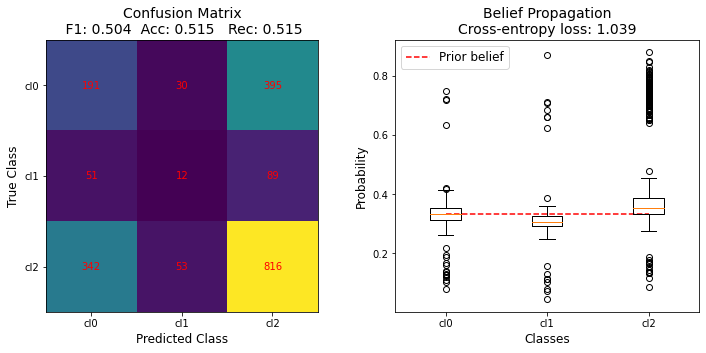

In [29]:
plots = evaluate_output(output)

In [ ]:
it.save_plot(plots, location='results/modelPerformance.png')

In [33]:
mapping = map_result(plots)

Not yet supported for more than two classes.
